<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/1dQW_on_ibm_brisbane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit-ibm-runtime qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0

Successfully imported Qiskit Runtime modules.
Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: ibm-q/open/main


<ipython-input-2-0048da2bf246>:42: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


IBM QiskitRuntimeService initialized directly with provided token.

Attempting to get QPU backend: ibm_brisbane from QiskitRuntimeService...
Selected QPU backend for Qiskit Runtime: ibm_brisbane (Qubits: 127, Status: active)

N_SITES=4, N_POS_QUBITS=2, Target initial_pos_val=2

Building QW circuit with Depth=2...

--- Generated QW Circuit ---
                  init       coin_s0 ┌─────────┐                  ┌─────────────┐┌─────────┐                ┌─────────────┐ shift_op_qft  step_s0       coin_s1 ┌─────────┐                  ┌─────────────┐┌─────────┐                ┌─────────────┐ shift_op_qft ┌─┐      
     pos_0: ───────░────────────░────┤0        ├─■────────────────┤0            ├┤0        ├─■──────────────┤0            ├──────░───────────░─────────────░────┤0        ├─■────────────────┤0            ├┤0        ├─■──────────────┤0            ├──────░───────┤M├──────
            ┌───┐  ░            ░    │  qft_d2 │ │                │  iqft_d2_dg ││  qft_i2 │ │              │  iqft

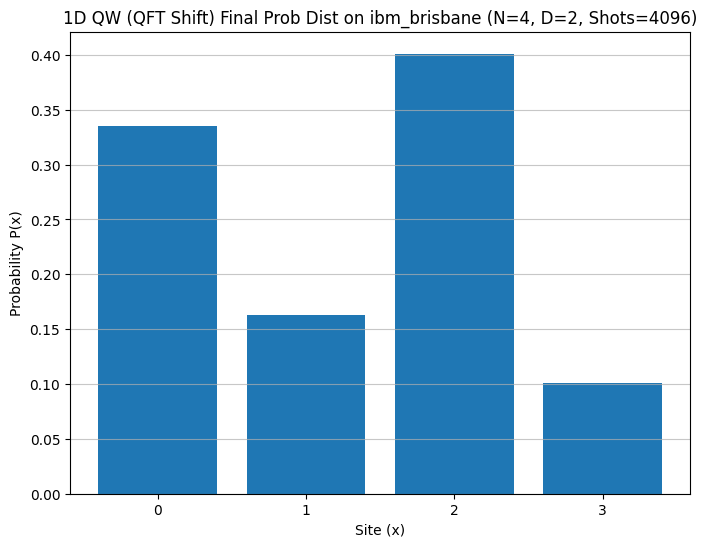


EXPERIMENT CONCLUDED. Please remember to invalidate the API token '99dd752798...' (used directly in this script) on the IBM Quantum website: https://quantum.ibm.com/account


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT # For QFT-based arithmetic

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. IBM Quantum execution will fail.")
    QiskitRuntimeService = None; Sampler = None; Session = None; generate_preset_pass_manager = None
    IBMRuntimeBackend = None
    qiskit_runtime_available = False

# --- Parameters for 1D QW Test ---
N_SITES = 4
N_POS_QUBITS = (N_SITES - 1).bit_length() if N_SITES > 0 else 0
N_COIN_QUBITS = 1
TOTAL_QUBITS = N_POS_QUBITS + N_COIN_QUBITS
DEPTH = 2    # REDUCED DEPTH FOR FIRST QPU RUN WITH QFT SHIFT
INITIAL_POS_VAL = N_SITES // 2 # Start at center (site 2 for N_SITES=4)

# --- IBM Quantum API Token and Instance Details ---
IBM_QUANTUM_TOKEN_DIRECT = 'API KEY HERE'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'
IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'

service = None
if qiskit_runtime_available:
    try:
        print(f"Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: {IBM_QUANTUM_INSTANCE_DIRECT}")
        service = QiskitRuntimeService(
            channel=IBM_QUANTUM_CHANNEL_DIRECT,
            instance=IBM_QUANTUM_INSTANCE_DIRECT,
            token=IBM_QUANTUM_TOKEN_DIRECT
        )
        print("IBM QiskitRuntimeService initialized directly with provided token.")
    except Exception as e:
        print(f"ERROR: Could not initialize QiskitRuntimeService directly with token: {e}")
        service = None
else:
    print("qiskit_ibm_runtime package is not available. Cannot use IBM Quantum Primitives.")

# --- Select Backend ---
backend = None
backend_name_to_print = "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'

if service:
    try:
        print(f"\nAttempting to get QPU backend: {backend_target_name} from QiskitRuntimeService...")
        qpu_backend_obj = service.backend(backend_target_name)
        if qpu_backend_obj:
            backend = qpu_backend_obj
            backend_name_to_print = backend.name
            current_status = backend.status()
            print(f"Selected QPU backend for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits}, Status: {current_status.status_msg})")
            if hasattr(backend, 'status') and callable(backend.status) and current_status.status_msg != 'active':
                print(f"WARNING: QPU {backend.name} status is {current_status.status_msg}. May not be ideal for running jobs.")
        else:
            print(f"QPU backend {backend_target_name} not found or not available via service.")
            backend = None
    except Exception as e_qpu:
        print(f"Could not get QPU backend '{backend_target_name}': {e_qpu}")

if backend is None:
    print("\nNo QPU backend successfully obtained. Falling back to local AerSimulator.")
    backend = AerSimulator()
    backend_name_to_print = "AerSimulator (local)"

# --- Define Qubit Registers and Circuit ---
pos_q = QuantumRegister(N_POS_QUBITS, name='pos')
coin_q = QuantumRegister(N_COIN_QUBITS, name='coin')
cr_combined = ClassicalRegister(TOTAL_QUBITS, name='meas_out')
qc = QuantumCircuit(pos_q, coin_q, cr_combined)

# --- Initial State ---
print(f"\nN_SITES={N_SITES}, N_POS_QUBITS={N_POS_QUBITS}, Target initial_pos_val={INITIAL_POS_VAL}")
for i in range(N_POS_QUBITS):
    if (INITIAL_POS_VAL >> i) & 1: qc.x(pos_q[i])
qc.barrier(label="init")

# --- QW Step Definition (Using QFT-based Shift) ---
def apply_coin_step_qiskit(circuit, coin_qubit_obj):
    circuit.h(coin_qubit_obj)

def apply_shift_step_qiskit_qft(circuit, coin_qubit, pos_register):
    n_pos = len(pos_register)
    if n_pos == 0: return

    # --- Decrement for coin |0> ---
    circuit.x(coin_qubit) # Condition on original coin state |0>
    circuit.append(QFT(n_pos, do_swaps=False, name=f'qft_d{n_pos}'), pos_register)
    for j in range(n_pos):
        angle_decrement = -np.pi / (2**j)
        circuit.cp(angle_decrement, coin_qubit, pos_register[j])
    circuit.append(QFT(n_pos, do_swaps=False, name=f'iqft_d{n_pos}').inverse(), pos_register)
    circuit.x(coin_qubit) # Flip coin_qubit back

    # --- Increment for coin |1> ---
    circuit.append(QFT(n_pos, do_swaps=False, name=f'qft_i{n_pos}'), pos_register)
    for j in range(n_pos):
        angle_increment = np.pi / (2**j)
        circuit.cp(angle_increment, coin_qubit, pos_register[j])
    circuit.append(QFT(n_pos, do_swaps=False, name=f'iqft_i{n_pos}').inverse(), pos_register)

    circuit.barrier(label="shift_op_qft")

# --- Evolution Loop ---
print(f"\nBuilding QW circuit with Depth={DEPTH}...")
for step in range(DEPTH):
    apply_coin_step_qiskit(qc, coin_q[0])
    qc.barrier(label=f"coin_s{step}")
    apply_shift_step_qiskit_qft(qc, coin_q[0], pos_q)
    if step < DEPTH - 1: qc.barrier(label=f"step_s{step}")

# --- Measurement ---
qc.measure(pos_q[:] + coin_q[:], cr_combined[:])

print("\n--- Generated QW Circuit ---")
try: print(qc.draw(output='text', fold=-1))
except Exception as e_draw: print(f"Could not draw circuit: {e_draw}")


# --- Transpile and Run ---
print(f"\n--- Transpiling and Running on {backend_name_to_print} ---")
counts = {}
try:
    shots = 4096
    isa_circuit = qc
    is_runtime_target = False
    if qiskit_runtime_available and service and backend:
        if IBMRuntimeBackend and isinstance(backend, IBMRuntimeBackend): is_runtime_target = True
        elif hasattr(backend, 'provider') and "runtime" in str(type(backend.provider)).lower() and backend.name != "aer_simulator": is_runtime_target = True

    if is_runtime_target and generate_preset_pass_manager is not None:
        print("Transpiling for Qiskit Runtime backend using preset pass manager...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1) # Level 1 for faster transpile
        isa_circuit = pm.run(qc)
        print(f"QW circuit depth original: {qc.depth()}, transpiled (ISA): {isa_circuit.depth()}")
    elif isinstance(backend, AerSimulator):
        print(f"Basic transpilation for {backend_name_to_print}...")
        isa_circuit = transpile(qc, backend=backend, optimization_level=1)
        print(f"QW circuit depth original: {qc.depth()}, transpiled: {isa_circuit.depth()}")
    else:
        print(f"Using original circuit for {backend_name_to_print} (depth: {qc.depth()}).")

    if is_runtime_target and Sampler is not None and Session is not None :
        print(f"Using QiskitRuntimeService SamplerV2 for backend: {backend.name}")
        with Session(backend=backend) as session:
            sampler = Sampler()
            pub = (isa_circuit,)
            job = sampler.run([pub], shots=shots)
            print(f"Job ID: {job.job_id()} submitted to Qiskit Runtime.")
            print("Waiting for results...")
            result = job.result()

            print("Processing SamplerV2 results...")
            if result and len(result) > 0:
                pub_result = result[0]
                classical_register_name_in_circuit = cr_combined.name
                if hasattr(pub_result.data, classical_register_name_in_circuit):
                    bit_array_obj = getattr(pub_result.data, classical_register_name_in_circuit)
                    if bit_array_obj is not None: counts = bit_array_obj.get_counts()
                    else: print(f"WARNING: Data for '{classical_register_name_in_circuit}' is None."); counts = {}
                elif hasattr(pub_result.data, 'meas'):
                    bit_array_obj = pub_result.data.meas
                    if bit_array_obj is not None: counts = bit_array_obj.get_counts()
                    else: print("WARNING: Data for 'meas' is None."); counts = {}
                else: print(f"WARNING: No '{classical_register_name_in_circuit}' or 'meas' field. Attrs: {dir(pub_result.data)}"); counts = {}
            else: print("ERROR: Job result is None or empty from SamplerV2."); counts = {}
    elif isinstance(backend, AerSimulator):
        print(f"Using legacy backend.run() for {backend_name_to_print}")
        job = backend.run(isa_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(0)
    else:
        print(f"ERROR: No suitable execution path found. Backend: {backend.name if backend else 'None'}")
        counts = {}

    print("\n--- Results ---")
    print("Counts:", counts)

    # --- Process and Analyze Results ---
    print("\n--- Analysis ---")
    prob_dist_x = np.zeros(N_SITES)
    if counts:
        for bitstring, count_val in counts.items():
            if len(bitstring) == TOTAL_QUBITS:
                try:
                    # Bitstring from measure_all: MSB is for last qubit in measure_all list
                    # Our measure list: pos_q[0], pos_q[1], ..., coin_q[0]
                    # So, coin bit is the MSB (leftmost bit of the string)
                    coin_binary_str = bitstring[:N_COIN_QUBITS]
                    pos_binary_str  = bitstring[N_COIN_QUBITS:]

                    measured_pos = int(pos_binary_str, 2)

                    if 0 <= measured_pos < N_SITES:
                        prob_dist_x[measured_pos] += count_val / shots
                    else: print(f"Warning: Parsed pos {measured_pos} from '{bitstring}' (pos_part='{pos_binary_str}') out of bounds for N_SITES={N_SITES}.")
                except ValueError as e_parse: print(f"Warning: Could not parse bitstring '{bitstring}': {e_parse}")
                except IndexError as e_idx: print(f"Warning: Index error parsing bitstring '{bitstring}': {e_idx}")
            else: print(f"Unexpected bitstring format/length: '{bitstring}' for TOTAL_QUBITS={TOTAL_QUBITS}")
    else:
        print("Counts dictionary is empty. Cannot calculate probability distribution.")

    if np.any(prob_dist_x) or not counts :
        plt.figure(figsize=(max(8, N_SITES*1.2),6))
        plt.bar(np.arange(N_SITES), prob_dist_x, width=0.8)
        plt.xlabel("Site (x)")
        plt.ylabel("Probability P(x)")
        plt.title(f"1D QW (QFT Shift) Final Prob Dist on {backend_name_to_print} (N={N_SITES}, D={DEPTH}, Shots={shots})")
        plt.xticks(np.arange(N_SITES))
        plt.grid(axis='y', alpha=0.7)
        plt.show()
    elif counts : print("Probability distribution is all zero (after parsing). Check circuit/parsing logic.")
    else: print("No counts data to plot.")

except Exception as main_e:
    print(f"An error occurred in the main script: {main_e}")
    import traceback
    traceback.print_exc()
finally:
    print(f"\nEXPERIMENT CONCLUDED. Please remember to invalidate the API token "
          f"'{IBM_QUANTUM_TOKEN_DIRECT[:10]}...' (used directly in this script) "
          f"on the IBM Quantum website: https://quantum.ibm.com/account")